In [1]:
import numpy as np
import torch 
import pandas as pd
import pickle
import time
import sys
import itertools
import pandas as pd

import matplotlib.pyplot as plt
from tueplots import axes, bundles
plt.rcParams.update({"figure.dpi": 150})

plt.rcParams.update(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
)

In [2]:
from scipy import stats
from scipy.stats import norm
from botorch.models.transforms.input import Warp

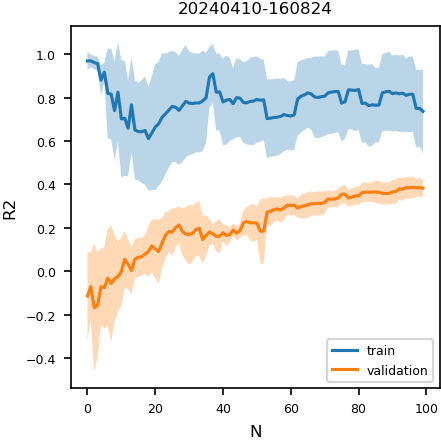

In [3]:
#plotting a learning curve
timestamp = "20240410-160824"
base_path = f"./output/{timestamp}"
seeds = [0,1,2,3,4]
trait = "narea"

with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    fig, ax = plt.subplots(1,1, figsize=(3,3))

    def getCol(col_name):
        _results = [pd.read_csv(f"{base_path}/gp_{seed}.npy", encoding='utf-8')[col_name] for seed in seeds]
        _results = [np.array(_results[i]) for i in range(0,len(_results))]
        return _results

    n = getCol("n")[0]
    train_loss = getCol("train_loss")
    val_loss = getCol("val_loss")

    def linePlot(ax, _results, label):
        mean, var = np.mean(_results, axis=0), np.std(_results, axis=0)
        ax.plot(n, mean, label=label)
        ax.fill_between(n, mean - var,  mean + var, alpha=0.3)
        return

    linePlot(ax, train_loss, label="train")
    linePlot(ax, val_loss, label="validation")

    ax = ax
    ax.set_title(f"{timestamp}") 
    ax.set_xlabel("N") 
    ax.set_ylabel("R2")
    ax.legend(loc="lower right")
    plt.show()

In [4]:
#load search space
from gp_fit import getLookup
table = getLookup("narea")

#define a lookup function
def lookup(X):
    X_indices = X.long().cpu()
    Y = table[X_indices[:, 0], X_indices[:, 1]].reshape(-1, 1)
    return Y.to(X)

#function to make zeros a small Z
def cleanZeros(Z):
    mask = Z == 0
    Z[mask] = 10e-6
    #zero_values = Z[Z == 0]
    return Z

def stadardize(data):
    mean = data.mean()
    std = data.std()    
    standardized_data = (data - mean) / std
    return standardized_data

/dfs/scratch0/ruhana/miniconda3/envs/genCorSearch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


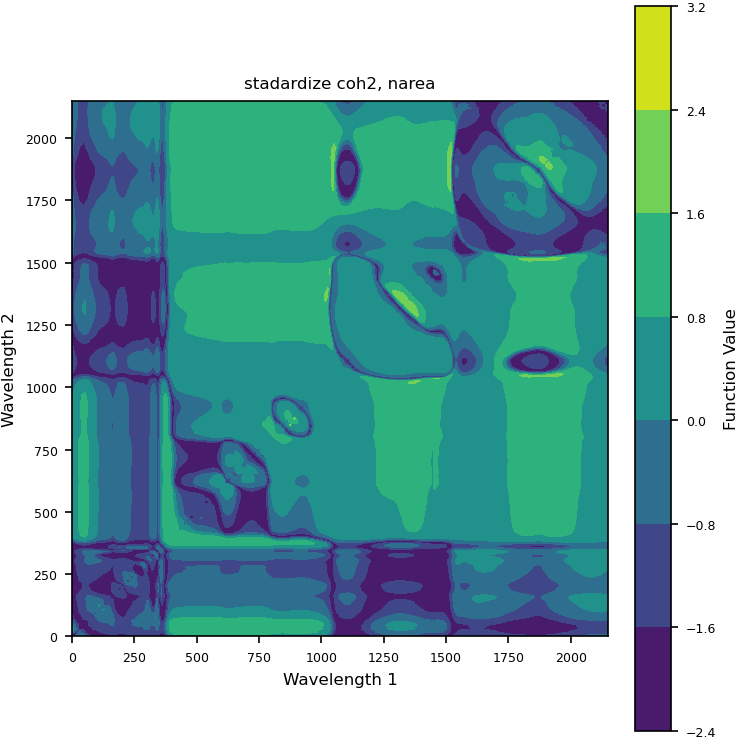

In [5]:
#visualize the search space
# Generate data for the plot
n=500
x1 = torch.linspace(0, 2150, n)
x2 = torch.linspace(0, 2150, n)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

Z = lookup(X)
Z = cleanZeros(Z)
Z = stadardize(Z)

# Create a contour plot
plt. figure(figsize=(5,5))
plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
cbar = plt.colorbar(label='Function Value')

# Add labels and title
plt.xlabel('Wavelength 1')
plt.ylabel('Wavelength 2')
plt.title("stadardize coh2, narea")

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')
cbar.ax.set_aspect(10, adjustable='box')
plt.show()

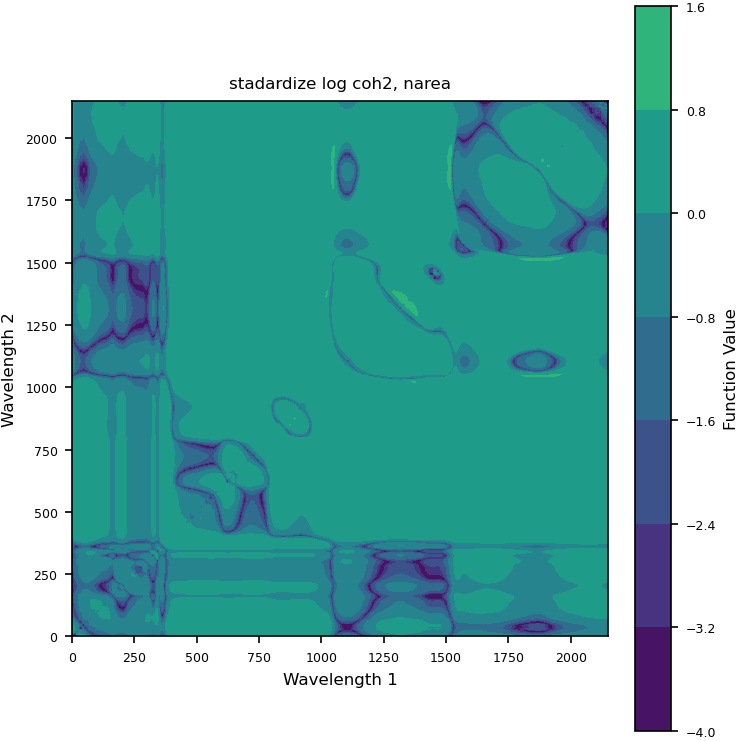

In [18]:
#visualize the search space
# Generate data for the plot
n=500
x1 = torch.linspace(0, 2150, n)
x2 = torch.linspace(0, 2150, n)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

Z = lookup(X)
Z = cleanZeros(Z)
Z = stadardize(torch.log(Z))

#to help with the plotting visuals
Z = torch.clamp(Z, -4, 4)

# Create a contour plot
plt. figure(figsize=(5,5))
plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis', vmin=-4, vmax=4)
cbar = plt.colorbar(label='Function Value')

# Add labels and title
plt.xlabel('Wavelength 1')
plt.ylabel('Wavelength 2')
plt.title("stadardize log coh2, narea")

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')
cbar.ax.set_aspect(10, adjustable='box')
plt.show()

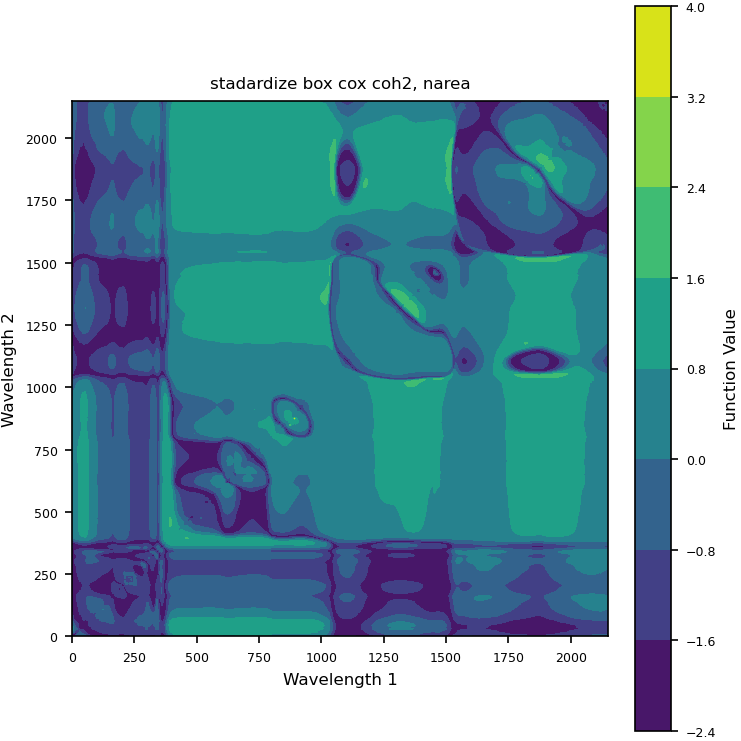

In [8]:
#visualize the search space
# Generate data for the plot
n=500
x1 = torch.linspace(0, 2150, n)
x2 = torch.linspace(0, 2150, n)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

Z = lookup(X)
Z = cleanZeros(Z)
fitted_data, fitted_lambda = stats.boxcox(Z.flatten())
Z = stadardize(fitted_data)

# Create a contour plot
plt. figure(figsize=(5,5))
plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
cbar = plt.colorbar(label='Function Value')

# Add labels and title
plt.xlabel('Wavelength 1')
plt.ylabel('Wavelength 2')
plt.title("stadardize box cox coh2, narea")

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')
cbar.ax.set_aspect(10, adjustable='box')
plt.show()

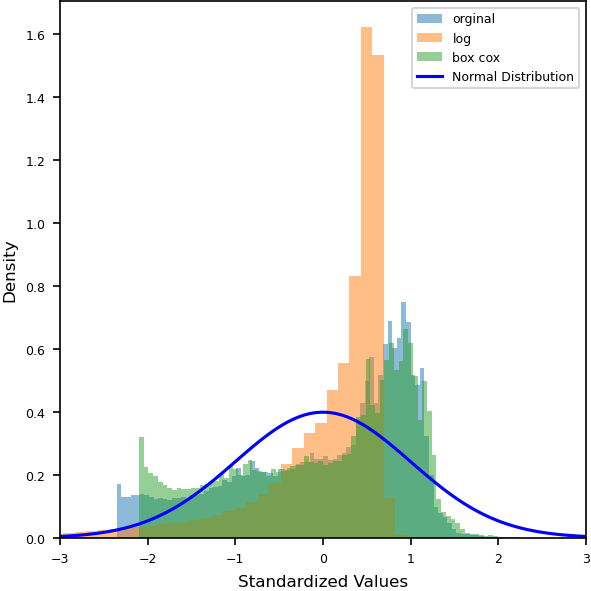

In [11]:
Z = lookup(X)
Z = cleanZeros(Z)

with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    plt.figure(figsize=(4,4))
    Z_prob, Z_bin, _ = plt.hist(stadardize(Z.flatten()), bins=100, density=True, alpha=0.5, label="orginal")
    Zlog_prob, Zlog_bin, _ = plt.hist(stadardize(torch.log(Z.flatten())), bins=100, density=True, alpha=0.5, label="log")
    
    fitted_data, fitted_lambda = stats.boxcox(Z.flatten())
    Zlog_prob, Zlog_bin, _ = plt.hist(stadardize(fitted_data), bins=100, density=True, alpha=0.5, label="box cox")
    
    mu = 0  # mean
    sigma = 1  # standard deviation
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2 / (2*sigma**2))

    # Plot the normal curve
    plt.plot(x, y, label='Normal Distribution', color='blue')
    
    plt.xlim(-3,3)
    plt.legend()

    plt.xlabel('Standardized Values')
    plt.ylabel('Density')
    #plt.title('Histogram ')
    plt.show()


In [ ]:
def kl_div(probabilities, bins):
    mean = 3
    std_dev = 1
    normal_probs = norm.pdf(bins, loc=mean, scale=std_dev)

    # Compute KL divergence
    kl_divergence = np.sum(probabilities * np.log(probabilities / normal_probs))
    return kl_divergence
    

In [ ]:
kl_div(Z_prob, Z_bin[:-1])

In [ ]:
Z_prob.sum()

In [ ]:
Z_bin.shape